In [32]:
## import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.metrics as metrics

In [33]:
## convert MNIST data into tensor of 4 dimensions (# of images, height, width, channel)
transforms = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transforms)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transforms)

100%|██████████| 9.91M/9.91M [00:00<00:00, 11.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 336kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.16MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.95MB/s]


In [34]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [36]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [37]:
## place data into dataloader with batch size
batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [38]:
## just use 2 CNN layers
c1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, padding=1)
c2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, padding=1)

In [39]:
## first use only one image from MNIST dataset
for i, (X_train, y_train) in enumerate(train_data):
    break

In [40]:
X_train.shape

torch.Size([1, 28, 28])

In [41]:
x = X_train.view(1,1,28,28)
x.shape

torch.Size([1, 1, 28, 28])

In [42]:
## first conv
x = F.relu(c1(x))
x.shape

torch.Size([1, 6, 28, 28])

In [43]:
## add pooling layer
x = F.max_pool2d(x, kernel_size=2, stride=2)
x.shape

torch.Size([1, 6, 14, 14])

In [44]:
x = F.relu(c2(x))
x.shape

torch.Size([1, 16, 14, 14])

In [45]:
## again pooling layer
x = F.max_pool2d(x, kernel_size=2, stride=2)
x.shape

torch.Size([1, 16, 7, 7])

In [46]:
## CNN model
class CNN_model(nn.Module):
    def __init__(self):
        super(CNN_model, self).__init__()
        self.c1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, padding=1)
        self.c2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(in_features=16*7*7, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)
    def forward(self, x):
        x = F.relu(self.c1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.c2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 16*7*7)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [48]:
## model implementation
torch.manual_seed(41)
model = CNN_model()
model

CNN_model(
  (c1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [49]:
## loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [51]:

import time
start = time.time()

## create variable to track things
epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

## for loop of epochs
for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    ## Train
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1  ## start from batch 1

        ## apply model
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        ## backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b%500 == 0:
            print(f'epoch: {i}  loss: {loss.item()}  batch: {b}')
    train_losses.append(loss)
    train_correct.append(trn_corr)

    ## test
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1]  ## add correct predictions
            tst_corr += (predicted == y_test).sum()  ## T=1, F=0, and sum

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)


current_time = time.time()
epoch_time = current_time - start
print(f'total time: {epoch_time/60} minutes')

epoch: 0  loss: 0.006620950996875763  batch: 500
epoch: 0  loss: 0.014094783924520016  batch: 1000
epoch: 0  loss: 0.23780031502246857  batch: 1500
epoch: 0  loss: 0.006187492981553078  batch: 2000
epoch: 0  loss: 0.2972339391708374  batch: 2500
epoch: 0  loss: 0.07996436208486557  batch: 3000
epoch: 0  loss: 0.011293014511466026  batch: 3500
epoch: 1  loss: 0.08494066447019577  batch: 500
epoch: 1  loss: 0.0013150112936273217  batch: 1000
epoch: 1  loss: 0.0031301076523959637  batch: 1500
epoch: 1  loss: 0.0040197488851845264  batch: 2000
epoch: 1  loss: 0.00270725111477077  batch: 2500
epoch: 1  loss: 0.11369669437408447  batch: 3000
epoch: 1  loss: 0.5057998895645142  batch: 3500
epoch: 2  loss: 0.005222008563578129  batch: 500
epoch: 2  loss: 0.007660682313144207  batch: 1000
epoch: 2  loss: 0.0012353337369859219  batch: 1500
epoch: 2  loss: 0.028943084180355072  batch: 2000
epoch: 2  loss: 0.020209114998579025  batch: 2500
epoch: 2  loss: 0.008422953076660633  batch: 3000
epoch: 2

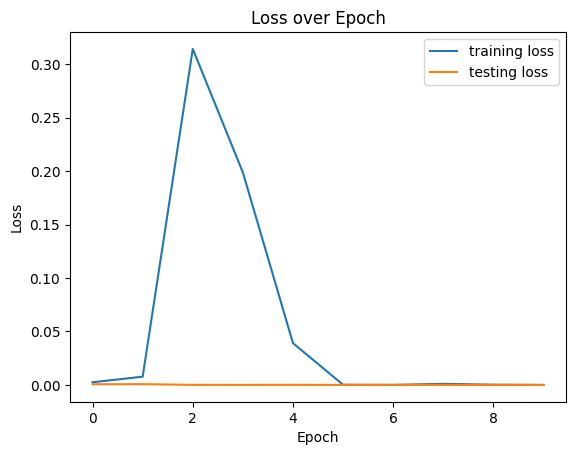

In [53]:
## plot loss over epoch
plt.plot([loss.item() for loss in train_losses], label='training loss')
plt.plot([loss.item() for loss in test_losses], label='testing loss')
plt.title('Loss over Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

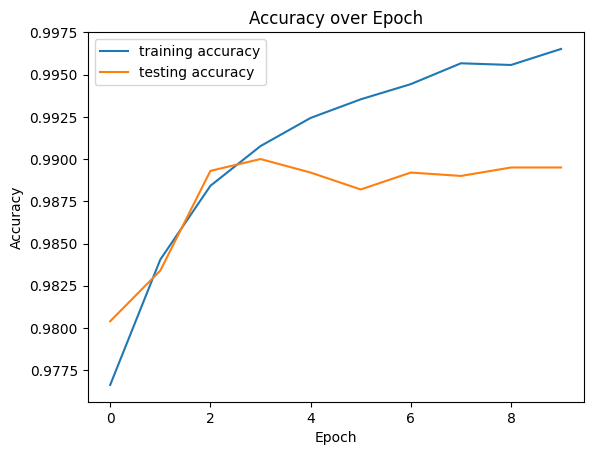

In [54]:
## plot accuracy
plt.plot([t/len(train_data) for t in train_correct], label='training accuracy')
plt.plot([t/len(test_data) for t in test_correct], label='testing accuracy')
plt.title('Accuracy over Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [60]:
## Load all test data in one batch without shuffling
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)

In [61]:
## Test model and count correct predictions
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_everything:
        y_val = model(X_test)
        predicted = torch.max(y_val.data, 1)[1]
        correct += (predicted == y_test).sum()
## check if correct
correct.item() / len(test_load_everything.dataset)

0.9895

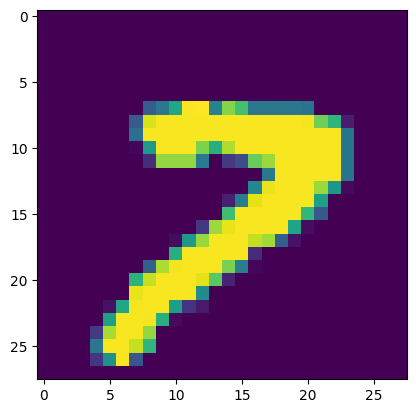

In [63]:
## test on any single image
test_data[4142][0].reshape(28,28).shape
## plot image
plt.imshow(test_data[4142][0].reshape(28,28))

In [64]:
## pass above image into model
model.eval()
with torch.no_grad():
    y_val = model(test_data[4142][0].view(1,1,28,28))  ##batch_size=1, color_channel = 1, image shape = (28,28)

## check prediction
torch.argmax(y_val)

tensor(7)